In [7]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

T_MIN, T_MAX = 18, 25        # °C
H_MIN, H_MAX = 35, 65        # %RH
VIBE_LIGHT   = 0.08          # g (RMS)

def analyze_and_plot(csv_path, title_tag=None, save_png=False, outdir="figures"):
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    df["sec"] = df["ms_since_start"] / 1000.0

    ok = (
        df["tempC"].between(T_MIN, T_MAX) &
        df["humidity"].between(H_MIN, H_MAX) &
        (df["accel_rms"] <= VIBE_LIGHT)
    ).astype(int)

    pct_ok   = ok.mean() * 100
    avg_temp = df["tempC"].mean()
    avg_rh   = df["humidity"].mean()
    flips    = int((ok.diff().fillna(0) != 0).sum() - 1)

    latest = df.iloc[-1]
    status = ("✅ Comfort OK" if
              (T_MIN <= latest["tempC"] <= T_MAX) and
              (H_MIN <= latest["humidity"] <= H_MAX) and
              (latest["accel_rms"] <= VIBE_LIGHT)
              else "⚠️ Action needed")

    tag = title_tag or csv_path.stem
    print(f"File: {csv_path.name}  |  Status: {status}")
    print(f"% Comfort OK: {pct_ok:.1f}%  |  Avg Temp: {avg_temp:.1f} °C  |  Avg RH: {avg_rh:.1f}%  |  Flips: {flips}")

    f1 = go.Figure([go.Scatter(x=df["sec"], y=df["tempC"], mode="lines", name="Temp °C")])
    f1.add_hline(y=T_MIN, line_dash="dash"); f1.add_hline(y=T_MAX, line_dash="dash")
    f1.update_layout(title=f"Temperature (°C) — {tag}", xaxis_title="Seconds", yaxis_title="°C")
    f1.show()

    f2 = go.Figure([go.Scatter(x=df["sec"], y=df["humidity"], mode="lines", name="RH %")])
    f2.add_hline(y=H_MIN, line_dash="dash"); f2.add_hline(y=H_MAX, line_dash="dash")
    f2.update_layout(title=f"Humidity (%) — {tag}", xaxis_title="Seconds", yaxis_title="%RH")
    f2.show()

    f3 = go.Figure([go.Scatter(x=df["sec"], y=df["accel_rms"], mode="lines", name="RMS g")])
    f3.add_hline(y=VIBE_LIGHT, line_dash="dash")
    f3.update_layout(title=f"Desk Vibration RMS (g) — {tag}", xaxis_title="Seconds", yaxis_title="g (RMS)")
    f3.show()

    if save_png:
        Path(outdir).mkdir(exist_ok=True)
        base = Path(outdir) / f"{csv_path.stem}"
        f1.write_image(str(base) + "_temp.png", scale=2)
        f2.write_image(str(base) + "_humidity.png", scale=2)
        f3.write_image(str(base) + "_vibe.png", scale=2)

    return {
        "file": csv_path.name,
        "status": status,
        "%_comfort_ok": round(pct_ok, 1),
        "avg_temp_C": round(avg_temp, 1),
        "avg_rh_%": round(avg_rh, 1),
        "comfort_flips": flips,
    }

File: comfort_A_comfortable.csv  |  Status: ✅ Comfort OK
% Comfort OK: 62.2%  |  Avg Temp: 19.1 °C  |  Avg RH: 67.5%  |  Flips: 3


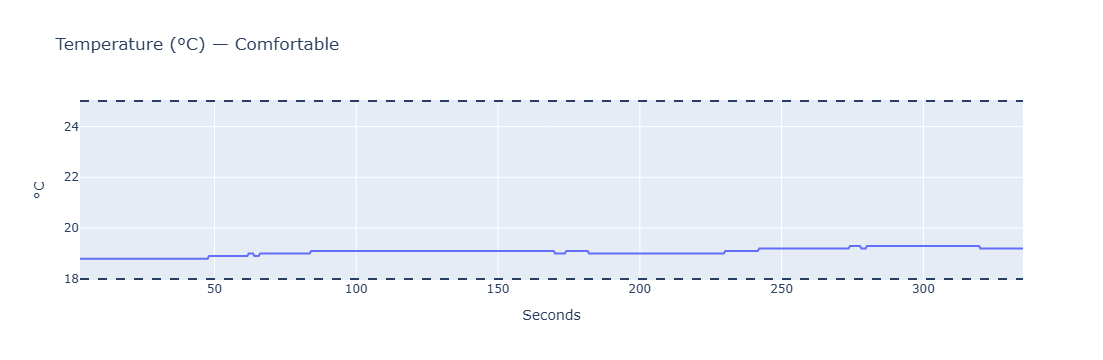

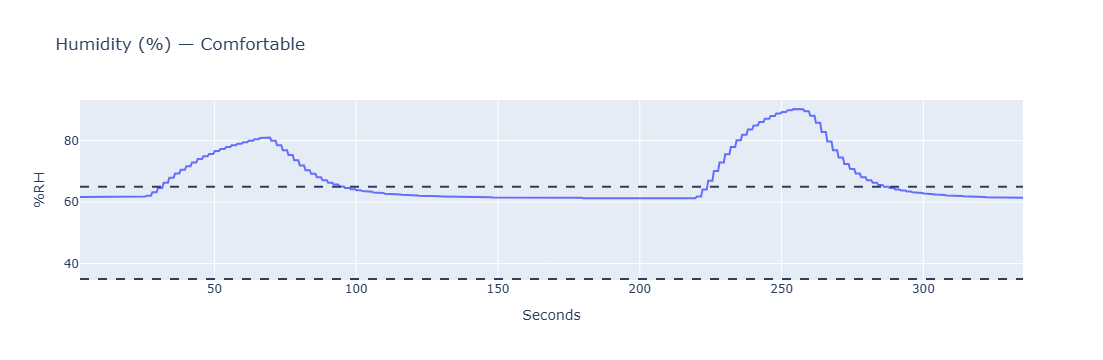

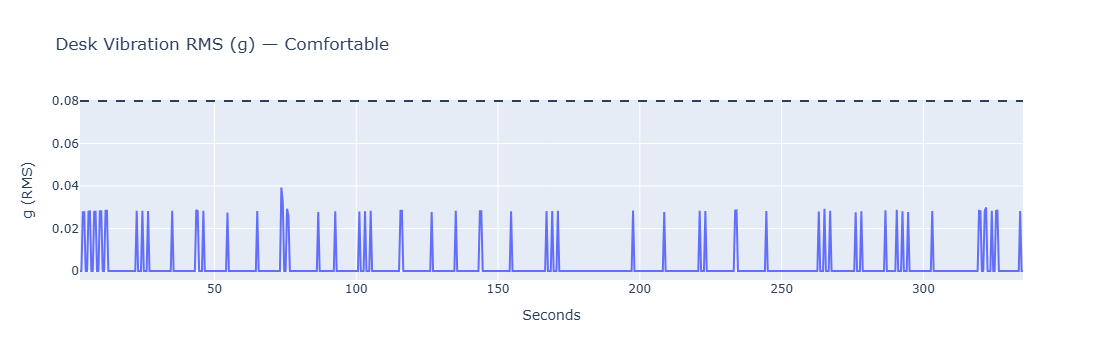

File: comfort_B_uncomfortable.csv  |  Status: ⚠️ Action needed
% Comfort OK: 0.0%  |  Avg Temp: 16.6 °C  |  Avg RH: 65.7%  |  Flips: -1


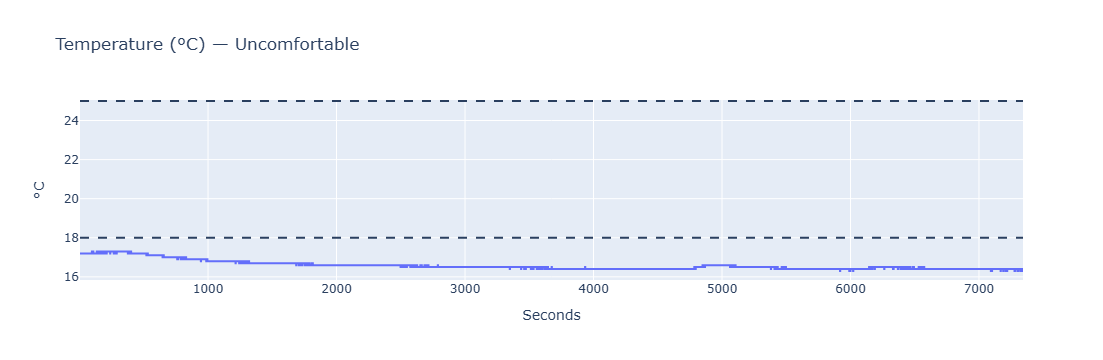

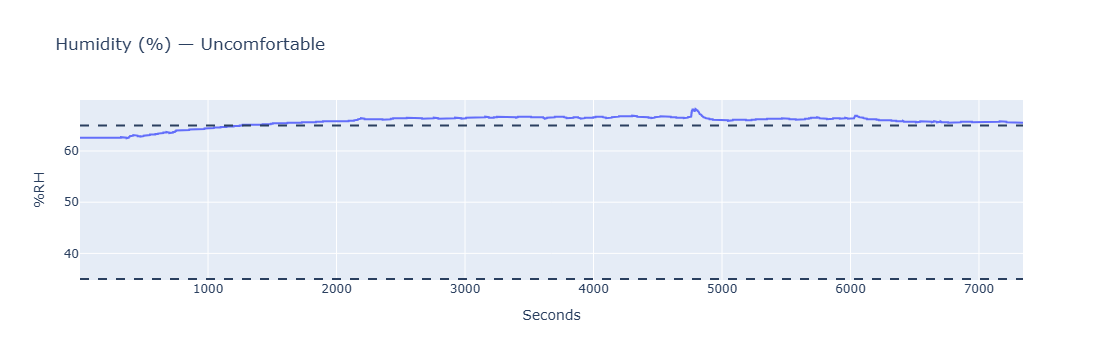

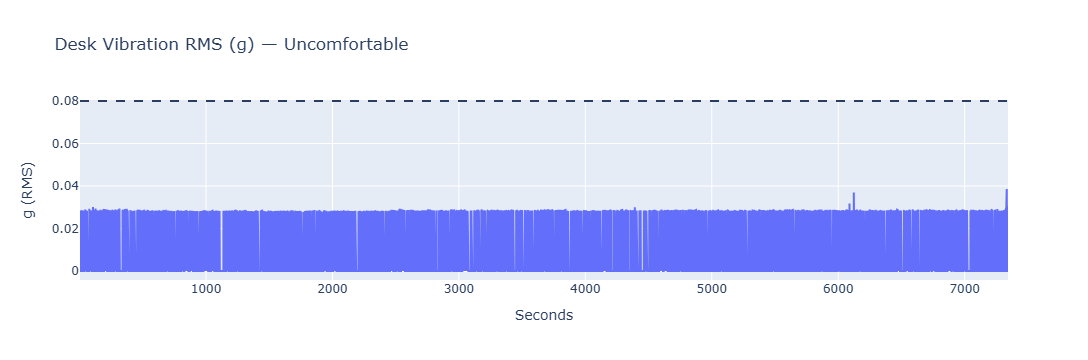

status  %_comfort_ok  avg_temp_C  \
file                                                                      
comfort_A_comfortable.csv        ✅ Comfort OK          62.2        19.1   
comfort_B_uncomfortable.csv  ⚠️ Action needed           0.0        16.6   

                             avg_rh_%  comfort_flips  
file                                                  
comfort_A_comfortable.csv        67.5              3  
comfort_B_uncomfortable.csv      65.7             -1

In [9]:
csv_A = "data captures/comfort_A_comfortable.csv"    
csv_B = "data captures/comfort_B_uncomfortable.csv"

mA = analyze_and_plot(csv_A, title_tag="Comfortable",   save_png=True)
mB = analyze_and_plot(csv_B, title_tag="Uncomfortable", save_png=True)

pd.DataFrame([mA, mB]).set_index("file")
